##  <p style="text-align: center;"> NX-421: Neural signals and signal processing, Miniproject-3: Variant 3
## <p style="text-align: center;"> Blind Source Separation

In [1]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style
from scipy.signal import butter
from scipy.signal import sosfiltfilt
import time
from scipy.ndimage import convolve1d
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler

#Load Data
subj1_mat = io.loadmat('data/subj1_relevant_vars')
print(f"What kind of data structure are we working with? {type(subj1_mat)}")
print(f"What are the keys of the data structure? \n {list(subj1_mat.keys())}")
N_CHANNELS = 64

What kind of data structure are we working with? <class 'dict'>
What are the keys of the data structure? 
 ['__header__', '__version__', '__globals__', 'Fs', 'adjusted_class_new', 'adjusted_repetition_new', 'emg_flexors_new']


In [2]:
subject_1_data = { 
      "name": "subject 1",
      "sampling_frequency": subj1_mat['Fs'][0][0],
      "emg_signal": subj1_mat['emg_flexors_new'].reshape(subj1_mat['emg_flexors_new'].shape[0], 64),
      "hand_mouvement_label": subj1_mat["adjusted_class_new"].flatten(),
      "repetition_number": subj1_mat['adjusted_repetition_new'].flatten()
              }
subject_1_data

{'name': 'subject 1',
 'sampling_frequency': 2048,
 'emg_signal': array([[-2.62174390e-03,  5.27681156e-03, -2.18451561e-03, ...,
         -5.76251744e-03,  9.00453354e-05,  1.99540053e-03],
        [ 7.67341356e-04,  4.82311690e-03,  1.77563149e-03, ...,
         -6.34514565e-04, -1.39659565e-03,  1.62779713e-03],
        [ 1.12907929e-03,  2.35519449e-03,  1.16431533e-03, ...,
          4.15876743e-04,  1.69310909e-03, -2.84820543e-03],
        ...,
        [-2.22037103e-02, -2.87452224e-02, -2.78726110e-02, ...,
          1.11979423e-02,  5.59196816e-03, -8.04352873e-02],
        [-3.05781494e-02, -3.21687935e-02, -2.30645220e-02, ...,
          1.15614242e-02,  8.61868146e-03, -9.26885810e-02],
        [-3.49523027e-02, -3.76635850e-02, -2.13010508e-02, ...,
          3.31225234e-03,  3.51837337e-03, -6.21802392e-02]]),
 'hand_mouvement_label': array([ 0,  0,  0, ..., 30, 30, 30], dtype=int8),
 'repetition_number': array([0, 0, 0, ..., 2, 2, 2], dtype=int8)}

## 1. Visualize and preprocess the data.

In [3]:
def preprocess_data(data, Wn = (5, 500), sub_sampling_rate=4):
    t = time.time()

    preprocessed = {}

    signal = data['emg_signal']
    fs = data['sampling_frequency']

    sos = butter(N=4, fs=fs, Wn=Wn, btype="bandpass", output="sos")
    emg_filtered = sosfiltfilt(sos, signal)

    emg_subsampled = emg_filtered[::sub_sampling_rate, :]
    emg_rectified =  emg_subsampled**2
    weights = np.ones(200)
    emg_envelopes = convolve1d(emg_rectified, weights=weights, axis=0)

    preprocessed['emg_signal'] = emg_envelopes
    preprocessed['sampling_frequency'] = fs/sub_sampling_rate
    preprocessed['hand_mouvement_label'] = data['hand_mouvement_label'][::sub_sampling_rate]
    preprocessed['repetition_number'] = data['repetition_number'][::sub_sampling_rate]
    preprocessed['name'] = data['name'] + 'preprocessed'

    print("Elapsed time: ", time.time() - t)
    return preprocessed

subject_1_preprocessed_data = preprocess_data(subject_1_data, sub_sampling_rate=2)

Elapsed time:  61.11065316200256


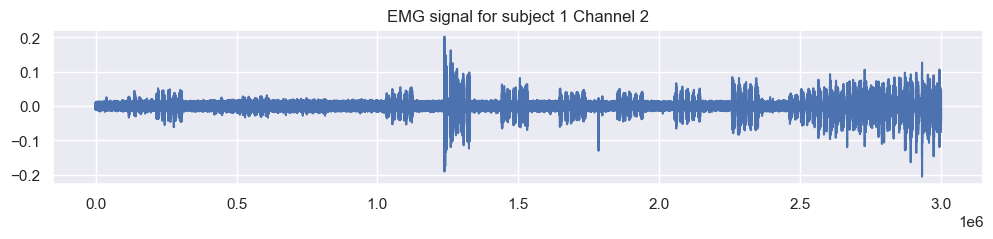

Sampling Frequency (Fs): 2048


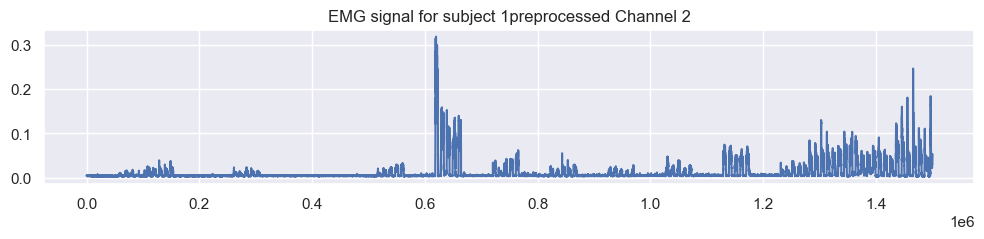

Sampling Frequency (Fs): 1024.0


In [4]:
def visualize_data(data, all = False): 
    signal = data["emg_signal"]

    #hand_mouvements  = data['hand_mouvement_label']
    #unique_movements = len(np.unique(hand_mouvements))
    #palette = sns.color_palette("Spectral", n_colors = unique_movements)
    #color_coding = [palette[idx] for idx in hand_mouvements]
    
    channel_number =  2
    plt.figure(figsize=(12, 2))
    plt.plot(signal[:, channel_number-1])#, c = color_coding)
    if (all): 
        plt.plot(signal)
    plt.title(f"EMG signal for {data['name']} Channel {channel_number}")
    plt.show()
    print(f"Sampling Frequency (Fs): {data['sampling_frequency']}")

visualize_data(subject_1_data)
visualize_data(subject_1_preprocessed_data)

## 2. Compute the spatial synergies using different blind source separation algorithms (e.g. PCA, ICA, NMF). Are the synergies stable?

In [16]:
signal = subject_1_preprocessed_data['emg_signal']
from sklearn.decomposition import NMF
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA

n_components = 3
nmf = NMF(n_components=n_components, init="nndsvda", max_iter=1000, random_state=0)
W_nmf = nmf.fit_transform(signal)
H_nmf = nmf.components_
print("W, H shape for nmf",W_nmf.shape, H_nmf.shape)

ica = FastICA(n_components=n_components, random_state=0, max_iter=1000)
W_ica= ica.fit_transform(signal)
H_ica = ica.components_
print("W, H shape for ica", W_ica.shape, H_ica.shape)

pca = PCA(n_components=n_components, random_state=0)
W_pca = pca.fit_transform(signal)
H_pca = pca.components_
print("W, H shape for pca", W_pca.shape, H_pca.shape)

pca_ica = FastICA(n_components=n_components, random_state=0, max_iter=1000)
W_pca_ica = pca_ica.fit_transform(W_pca)
H_pca_ica = pca_ica.components_

H_pca_ica = H_pca_ica.T @ H_pca

print("W, H shape for pca + ica", W_pca_ica.shape, H_pca_ica.shape)

W, H shape for nmf (1500000, 3) (3, 64)
W, H shape for ica (1500000, 3) (3, 64)
W, H shape for pca (1500000, 3) (3, 64)
W, H shape for pca + ica (1500000, 3) (3, 64)


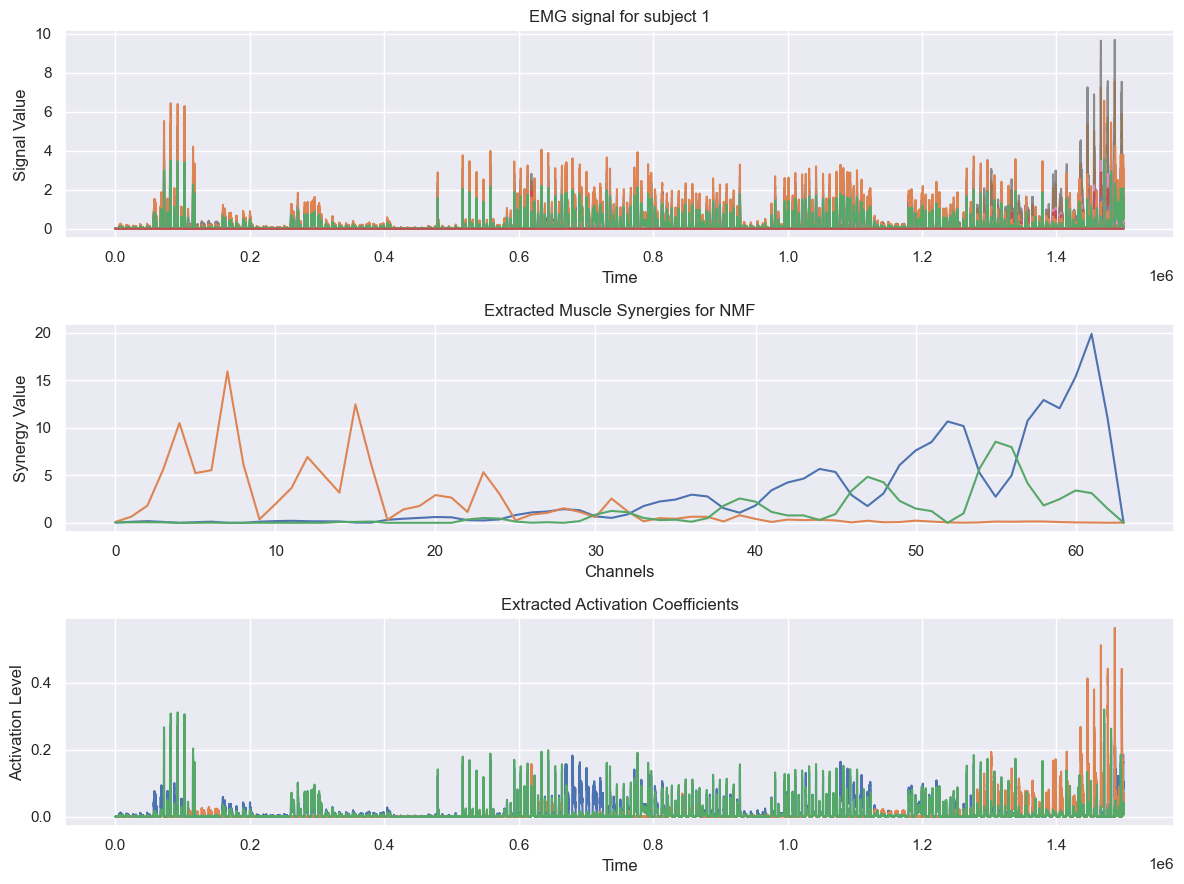

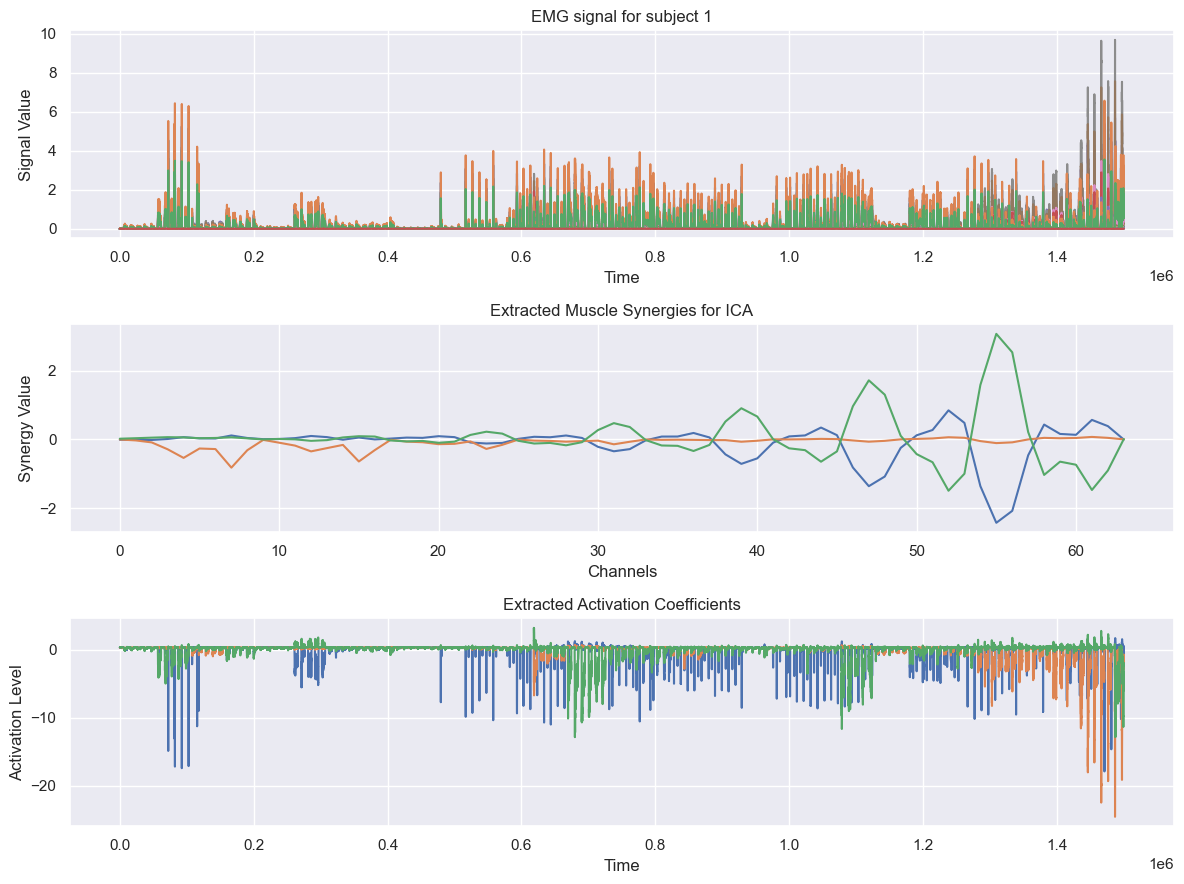

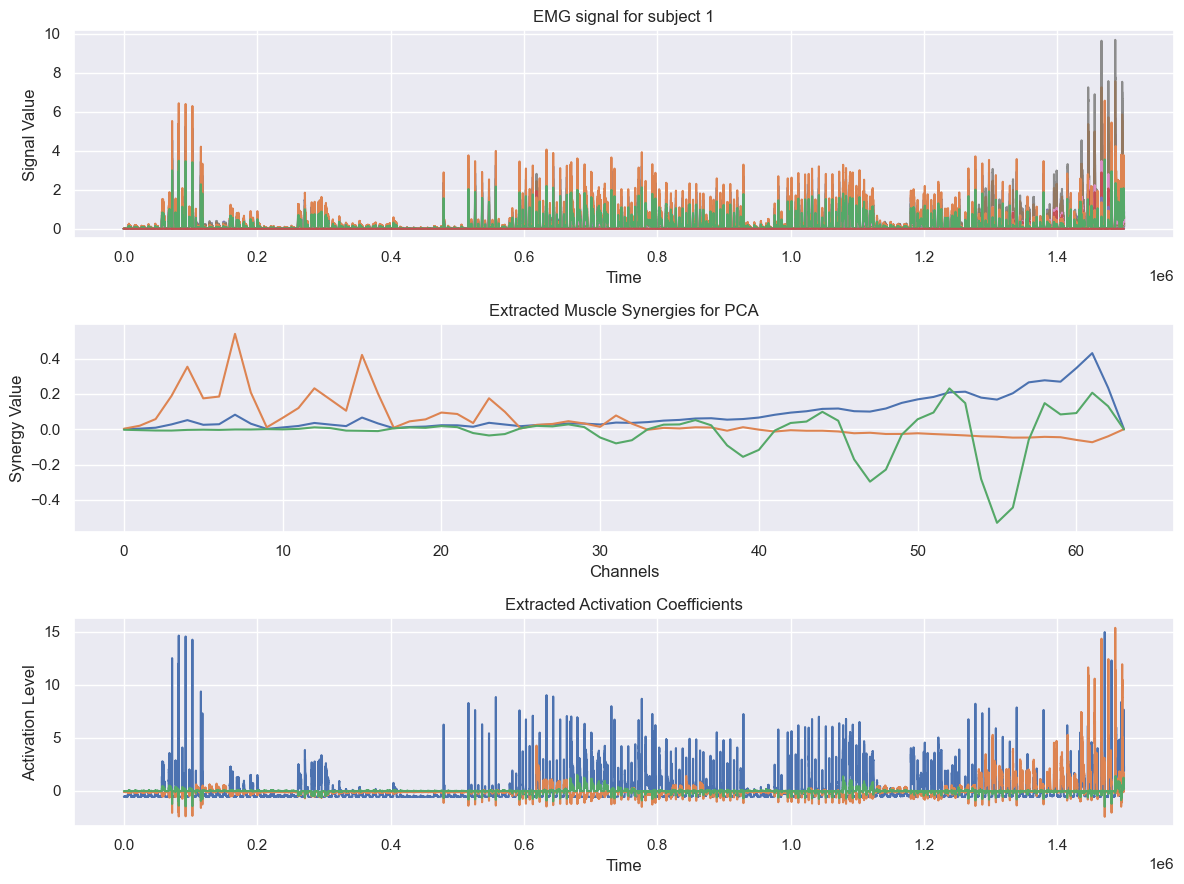

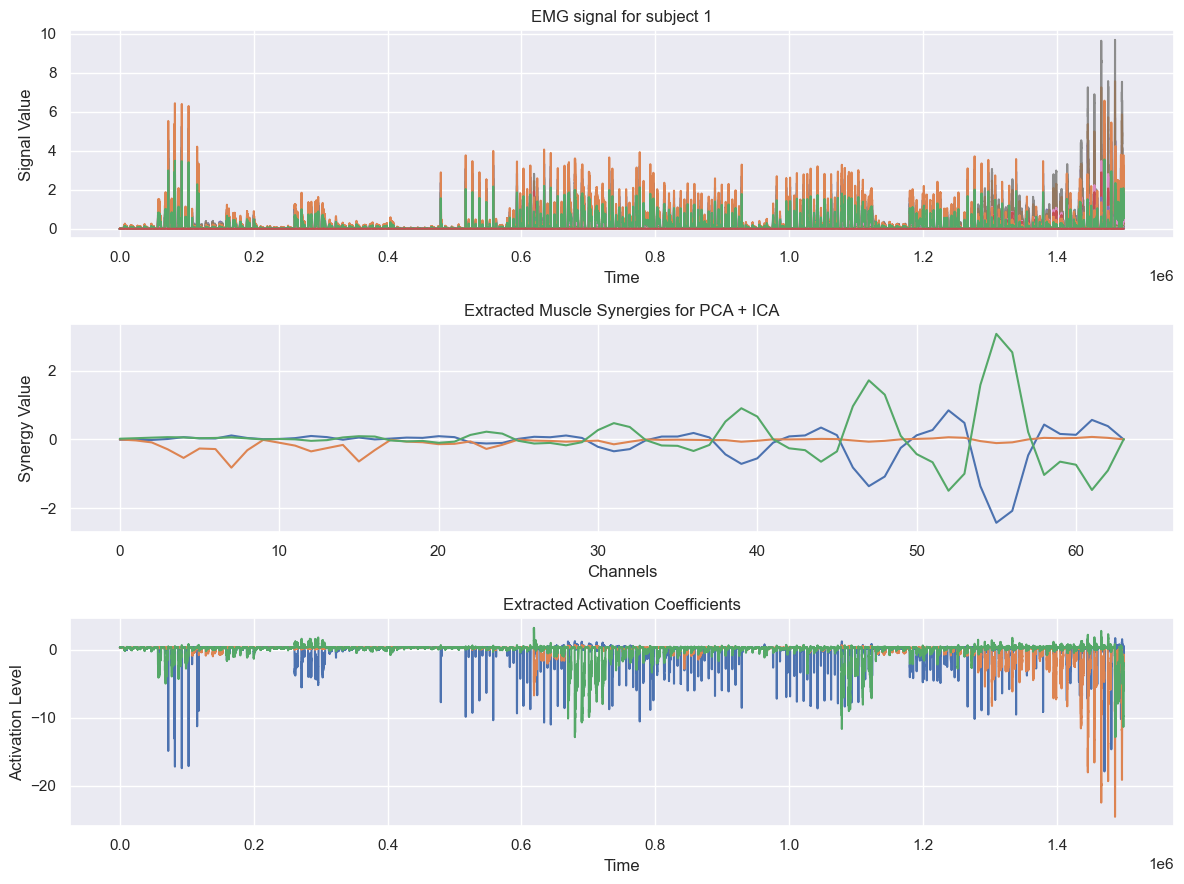

In [14]:
def visualize_synergies(W, H, signal, names = ["EMG signal", "W", "H"], all = True): 
    
    if (all):
        fig, ax = plt.subplots(3, 1, figsize = (12, 9))
        ax[0].plot(signal)
        ax[0].set_title("EMG signal" + names[0])
        ax[0].set_xlabel('Time')
        ax[0].set_ylabel('Signal Value')

        ax[1].plot(H.T)
        ax[1].set_title('Extracted Muscle Synergies' + names[1])
        ax[1].set_xlabel('Channels')
        ax[1].set_ylabel('Synergy Value')

        ax[2].plot(W)
        ax[2].set_title('Extracted Activation Coefficients' + names[2])
        ax[2].set_xlabel('Time')
        ax[2].set_ylabel('Activation Level')
        plt.tight_layout()
        plt.show()
    else: 
        plt.figure(figsize=(12, 2))
        plt.plot(H.T)
        plt.title('Extracted Muscle Synergies' + names[1])
        plt.xlabel('Channels')
        plt.ylabel('Synergy Value')
        plt.show()


visualize_synergies(W_nmf, H_nmf, signal=subject_1_preprocessed_data['emg_signal'], names = [" for subject 1", " for NMF", ""])
visualize_synergies(W_ica, H_ica, signal=subject_1_preprocessed_data['emg_signal'], names = [" for subject 1", " for ICA", ""])
visualize_synergies(W_pca, H_pca, signal=subject_1_preprocessed_data['emg_signal'], names = [" for subject 1", " for PCA", ""])
visualize_synergies(W_pca_ica, H_pca_ica, signal=subject_1_preprocessed_data['emg_signal'], names = [" for subject 1", " for PCA + ICA", ""])

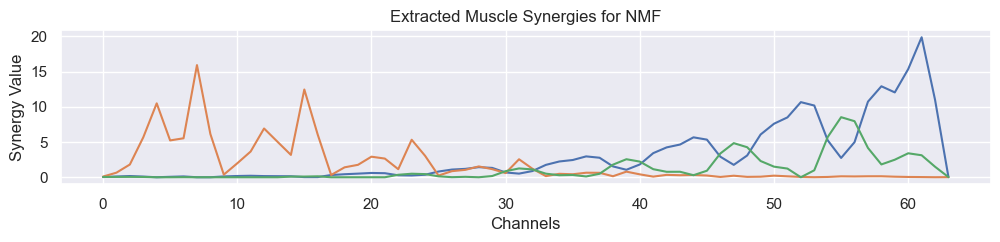

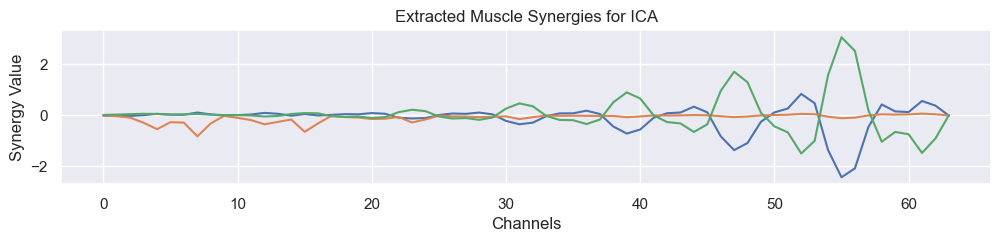

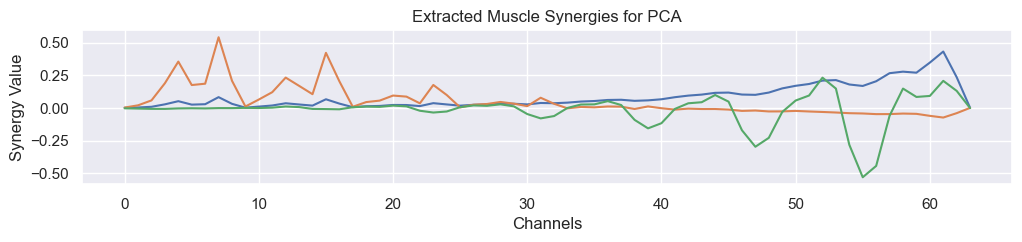

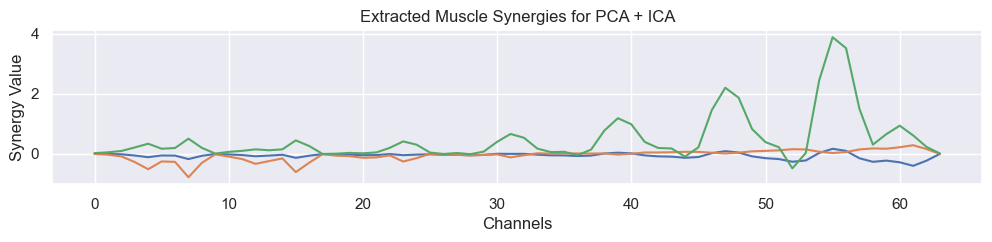

In [17]:
visualize_synergies(W_nmf, H_nmf, signal=subject_1_preprocessed_data['emg_signal'], names = [" for subject 1", " for NMF", ""], all = False)
visualize_synergies(W_ica, H_ica, signal=subject_1_preprocessed_data['emg_signal'], names = [" for subject 1", " for ICA", ""], all = False)
visualize_synergies(W_pca, H_pca, signal=subject_1_preprocessed_data['emg_signal'], names = [" for subject 1", " for PCA", ""], all = False)
visualize_synergies(W_pca_ica, H_pca_ica, signal=subject_1_preprocessed_data['emg_signal'], names = [" for subject 1", " for PCA + ICA", ""], all = False)

To calculate the stability we can use the Synergy Stability Coefficient

In [23]:
#Synergy stability based off of Muscle synergy stability and human balance maintenance by Tytus Wojtara (2014)
def compute_ssi(synergies_list): #Synergies as a list of matrix synergies
    
    ssi_sum = 0

    #normalize muscle synergies
    normalized = []
    scaler = StandardScaler()
    for ms in synergies_list: 
        ms_scaled = scaler.fit_transform(ms)
        normalized.append(ms_scaled)

    #get dimensions
    number_of_trials = len(synergies_list)
    number_of_muscle_synergies = synergies_list[0].shape[0]

    p = number_of_trials
    k = number_of_muscle_synergies

    w = normalized
    for i in range(0, k):
        inner_sum = 0
        
        for l in range(p):
            for q in range(p):
                if l != q:
                    correlation, pval = pearsonr(w[l][i], w[q][i])
                    inner_sum += correlation
        ssi_sum += (1 / (p * (p - 1))) * inner_sum
    
    ssi = 1 / k * ssi_sum
    return ssi

print(compute_ssi([H_ica, H_pca_ica]))
compute_ssi([H_nmf, H_ica, H_pca])

0.40379911701031246


-0.09280140768853096

So after careful analysis of our plots, we can see our synergies are not stable accross BSS algorithms yielding a negative SSI of -.09 

## 3. Compute the spatial synergies corresponding to different subsets of the data samples. Are the synergies stable across the different subsets?

Lets compute the spatial synergies accross trial repetition numbers and hand movement subsets

In [38]:
df = pd.DataFrame(subject_1_preprocessed_data['emg_signal'])
df.insert(0, "repetition_number", subject_1_preprocessed_data['repetition_number'])
df.insert(1, "hand_movement", subject_1_preprocessed_data['hand_mouvement_label'])
df.sample()

repetition_number  hand_movement         0        1         2  \
1155866                  0              0  0.000501  0.00482  0.008235   

                3       4         5         6        7  ...       54  \
1155866  0.006515  0.0054  0.005533  0.005731  0.00632  ...  0.02264   

               55        56        57        58        59        60        61  \
1155866  0.022832  0.025687  0.029906  0.030129  0.030207  0.039448  0.048449   

               62        63  
1155866  0.026435  0.000141  

[1 rows x 66 columns]

In [25]:
def synergies_across_subsets(df, method, subset_category= "repetition_number", one_movement = None):

    ds = df.copy()
    if (one_movement is not None):
        ds = df[df["hand_movement"] == one_movement]
    
    unique_vals = ds[subset_category].drop_duplicates().values.tolist()
    
    list_of_synergies = []
    for val in unique_vals: 
        subset = ds[ds[subset_category] == val] 
        signal = subset.iloc[:, 2:]
        W = method.fit_transform(signal)
        H = method.components_
        list_of_synergies.append(H)
        #print(val)
    return list_of_synergies


def synergies_across_subsets_pca_ica(df, subset_category= "repetition_number", one_movement = None):

    ds = df.copy()
    if (one_movement is not None):
        ds = df[df["hand_movement"] == one_movement]
    
    unique_vals = ds[subset_category].drop_duplicates().values.tolist()
    
    list_of_synergies = []
    for val in unique_vals: 
        subset = ds[ds[subset_category] == val] 
        signal = subset.iloc[:, 2:]
        W = pca.fit_transform(signal)
        H = pca.components_
        W = ica.fit_transform(W)
        H_pca_ica = ica.components_
        H_pca_ica = H_pca_ica.T @ H
        list_of_synergies.append(H_pca_ica)
        #print(val)
    return list_of_synergies

print("nmf")
list_of_synergies_repetitions_nmf = synergies_across_subsets(df, method=nmf, subset_category="repetition_number")
print("ica")
list_of_synergies_repetitions_ica = synergies_across_subsets(df, method=ica, subset_category="repetition_number")
print("pca")
list_of_synergies_repetitions_pca = synergies_across_subsets(df, method=pca, subset_category="repetition_number")

print("pca+ica")
list_of_synergies_repetitions_pca_ica = synergies_across_subsets_pca_ica(df, subset_category="repetition_number")

nmf


c:\Users\LEGION\miniconda3\envs\DEEPLABCUT\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\LEGION\miniconda3\envs\DEEPLABCUT\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


ica
pca
pca+ica


### a. Visualize for NMF 

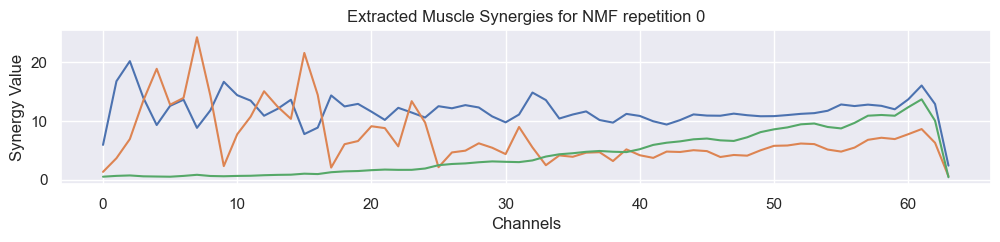

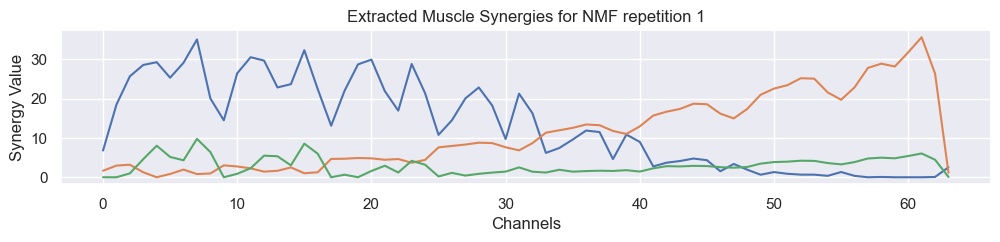

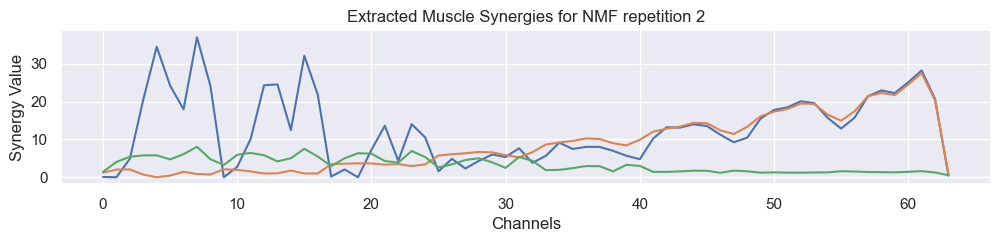

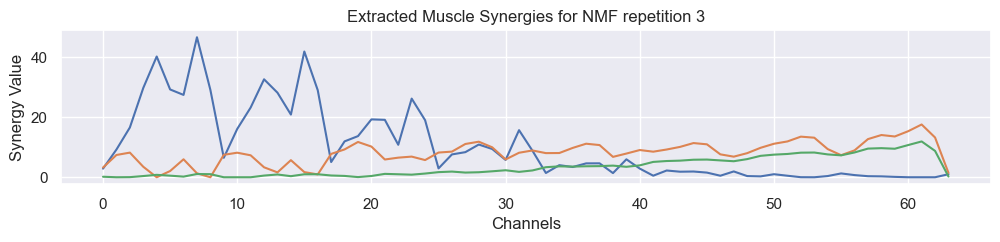

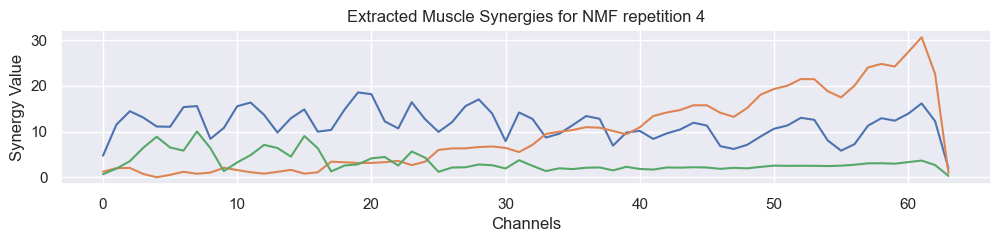

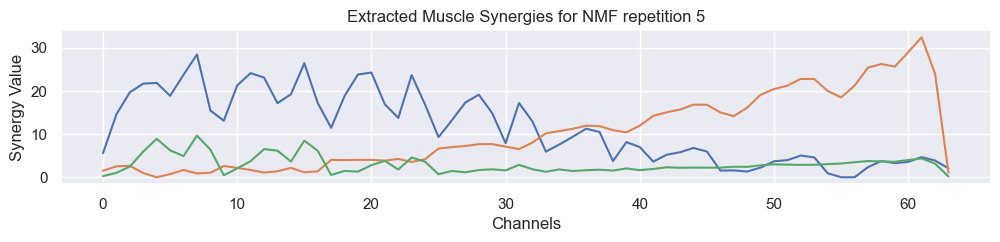

In [141]:
for rdx, muscle_synergy in enumerate(list_of_synergies_repetitions_nmf):
    visualize_synergies(W=None, H=muscle_synergy, signal=None, names = ["", f" for NMF repetition {rdx}", ""], all = False)

### b. Visualize for ICA

FOR ICA


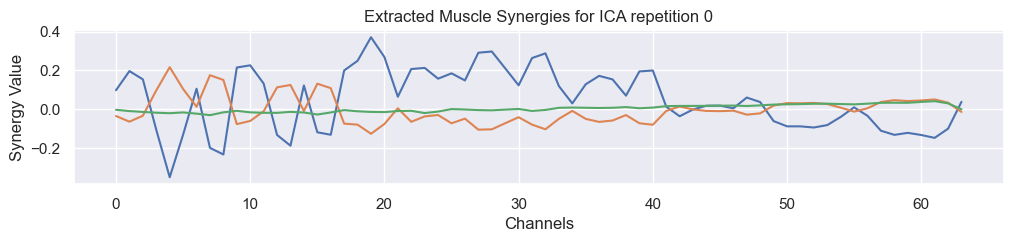

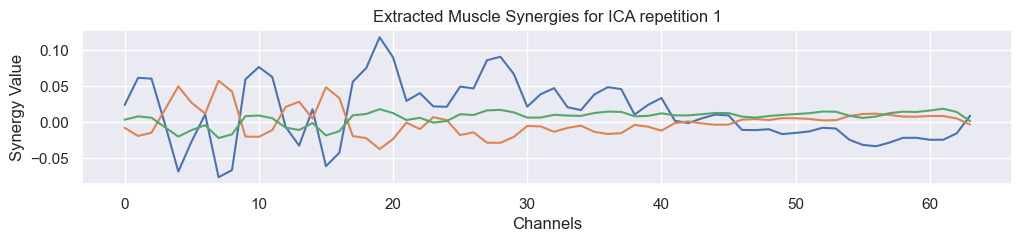

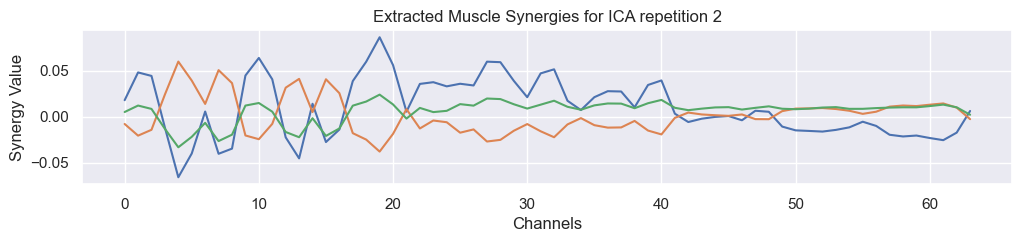

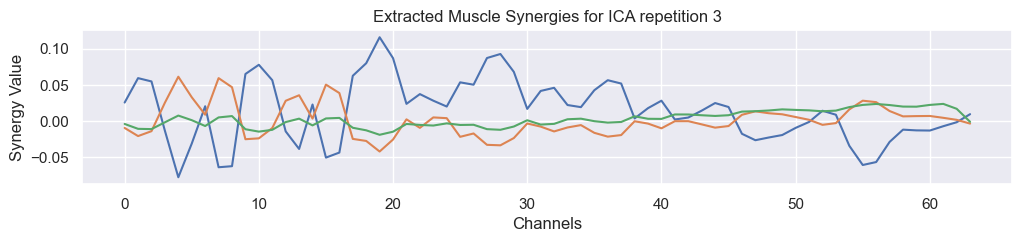

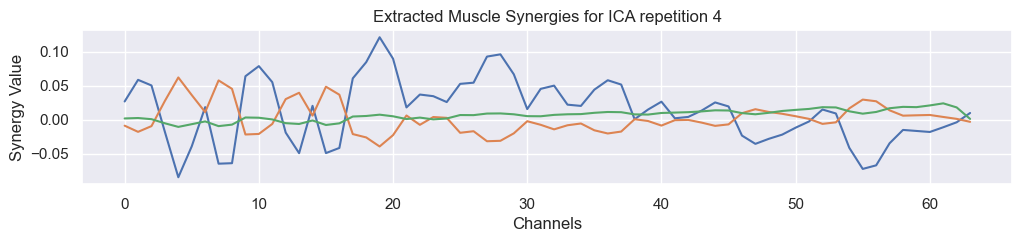

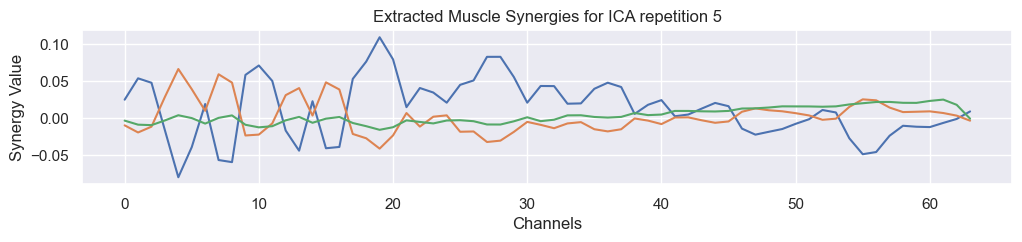

In [142]:
print("FOR ICA")
for rdx, muscle_synergy in enumerate(list_of_synergies_repetitions_ica):
    visualize_synergies(W=None, H=muscle_synergy, signal=None, names = ["", f" for ICA repetition {rdx}", ""], all = False)

### c. Visualize for PCA

FOR PCA


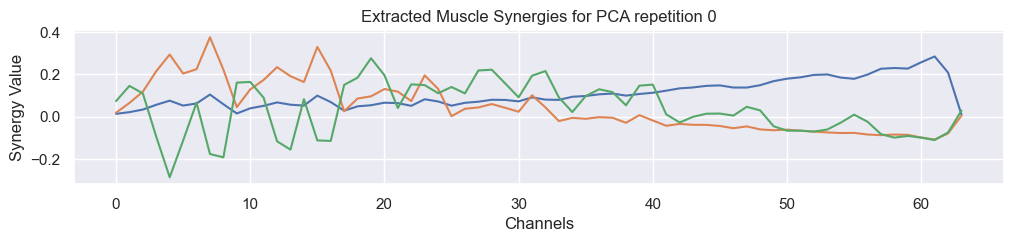

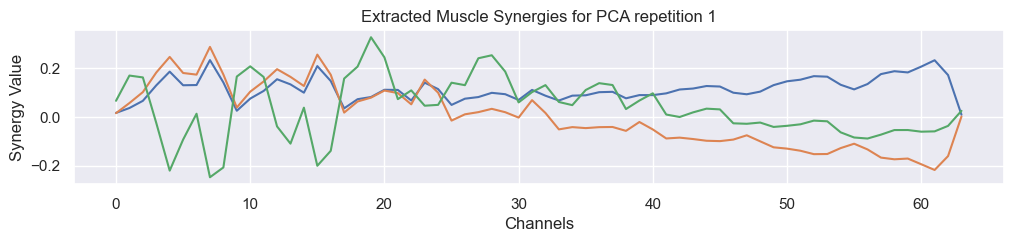

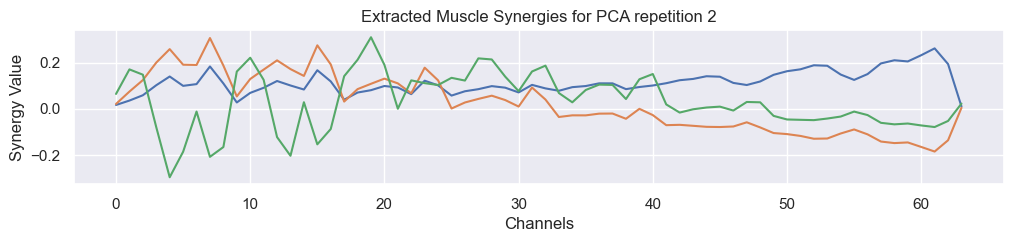

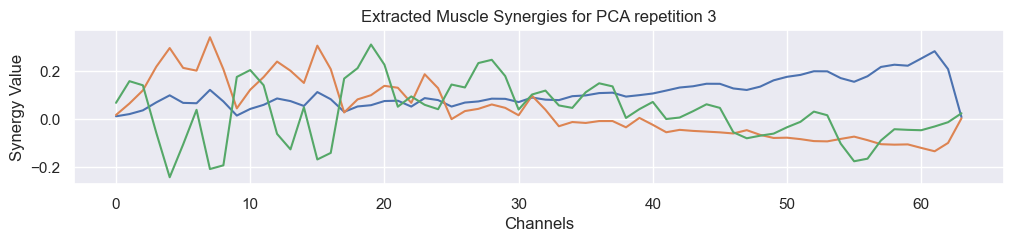

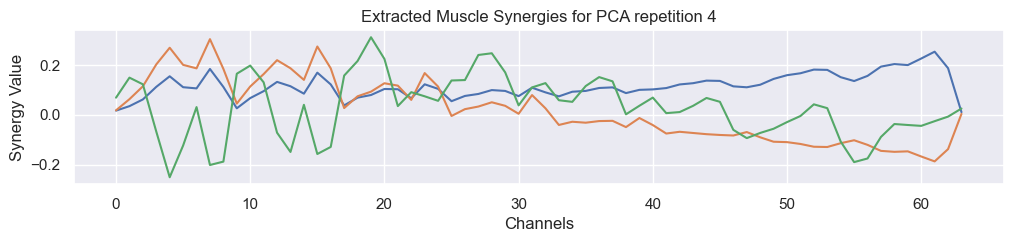

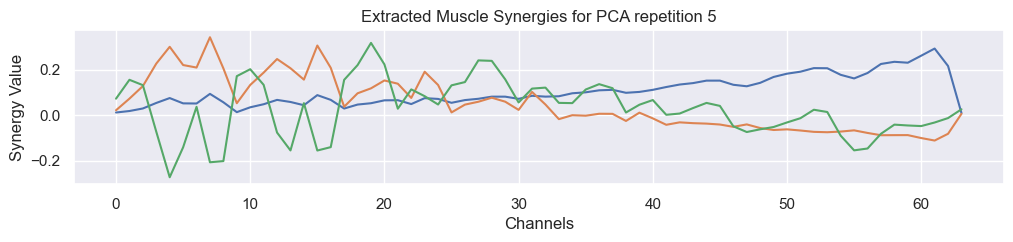

In [145]:
for rdx, muscle_synergy in enumerate(list_of_synergies_repetitions_pca):
    visualize_synergies(W=None, H=muscle_synergy, signal=None, names = ["", f" for PCA repetition {rdx}", ""], all = False)

### What about the stability accross trial repetition subsets?

In [26]:
print("NMF SSI =",compute_ssi(list_of_synergies_repetitions_nmf),
        "\nICA SSI =",compute_ssi(list_of_synergies_repetitions_ica),
        "\nPCA SSI =",compute_ssi(list_of_synergies_repetitions_pca))

print("NMF SSI =",compute_ssi(list_of_synergies_repetitions_nmf),
        "\nICA SSI =",compute_ssi(list_of_synergies_repetitions_ica),
        "\nPCA SSI =",compute_ssi(list_of_synergies_repetitions_pca),
        "\nPCA+ICA SSI =",compute_ssi(list_of_synergies_repetitions_pca_ica))

NMF SSI = 0.6702291364137407 
ICA SSI = -0.1488776411027361 
PCA SSI = 0.6197827112382082
NMF SSI = 0.6702291364137407 
ICA SSI = -0.1488776411027361 
PCA SSI = 0.6197827112382082 
PCA+ICA SSI = -0.11638763214493138


### The second subset we considered is accross hand movements

In [39]:
print("nmf")
list_of_synergies_movements_nmf = synergies_across_subsets(df, method=nmf, subset_category="hand_movement")
print("ica")
list_of_synergies_movements_ica = synergies_across_subsets(df, method=ica, subset_category="hand_movement")
print("pca")
list_of_synergies_movements_pca = synergies_across_subsets(df, method=pca, subset_category="hand_movement")

print("pca+ica")
list_of_synergies_movements_pca_ica = synergies_across_subsets_pca_ica(df, subset_category="hand_movement")

nmf


c:\Users\LEGION\miniconda3\envs\DEEPLABCUT\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\LEGION\miniconda3\envs\DEEPLABCUT\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\LEGION\miniconda3\envs\DEEPLABCUT\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\LEGION\miniconda3\envs\DEEPLABCUT\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\LEGION\miniconda3\envs\DEEPLABCUT\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 10

ica


c:\Users\LEGION\miniconda3\envs\DEEPLABCUT\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


pca
pca+ica


c:\Users\LEGION\miniconda3\envs\DEEPLABCUT\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


### The stability of the muscle synergy of each method accross different hand movements is correclty very bad

In [40]:
print("NMF SSI =",compute_ssi(list_of_synergies_movements_nmf),
        "\nICA SSI =",compute_ssi(list_of_synergies_movements_ica),
        "\nPCA SSI =",compute_ssi(list_of_synergies_movements_pca))

print("NMF SSI =",compute_ssi(list_of_synergies_movements_nmf),
        "\nICA SSI =",compute_ssi(list_of_synergies_movements_ica),
        "\nPCA SSI =",compute_ssi(list_of_synergies_movements_pca),
        "\nPCA+ICA SSI =",compute_ssi(list_of_synergies_movements_pca_ica))

NMF SSI = 0.1309225250710785 
ICA SSI = -0.0036238877686736596 
PCA SSI = 0.09701067722875559
NMF SSI = 0.1309225250710785 
ICA SSI = -0.0036238877686736596 
PCA SSI = 0.09701067722875559 
PCA+ICA SSI = 0.06545597897282829


### The third and last subset we considered is the repetitions of a single movement and we chose movement with label = 1

In [27]:
movement_number = 1
print("nmf")
list_of_synergies_repetitions_one_movement_nmf = synergies_across_subsets(df, method=nmf,
                                                                           subset_category="repetition_number", one_movement=movement_number)
print("ica")
list_of_synergies_repetitions_one_movement_ica = synergies_across_subsets(df, method=ica,
                                                                           subset_category="repetition_number", one_movement=movement_number)
print("pca")
list_of_synergies_repetitions_one_movement_pca = synergies_across_subsets(df, method=pca,
                                                                           subset_category="repetition_number", one_movement=movement_number)

print("pca+ica")
list_of_synergies_repetitions_one_movement_pca_ica = synergies_across_subsets_pca_ica(df,
                                                                           subset_category="repetition_number", one_movement=movement_number)

nmf


c:\Users\LEGION\miniconda3\envs\DEEPLABCUT\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\LEGION\miniconda3\envs\DEEPLABCUT\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\LEGION\miniconda3\envs\DEEPLABCUT\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\LEGION\miniconda3\envs\DEEPLABCUT\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\LEGION\miniconda3\envs\DEEPLABCUT\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 10

ica


c:\Users\LEGION\miniconda3\envs\DEEPLABCUT\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


pca
pca+ica


c:\Users\LEGION\miniconda3\envs\DEEPLABCUT\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


### a. Visualize for NMF

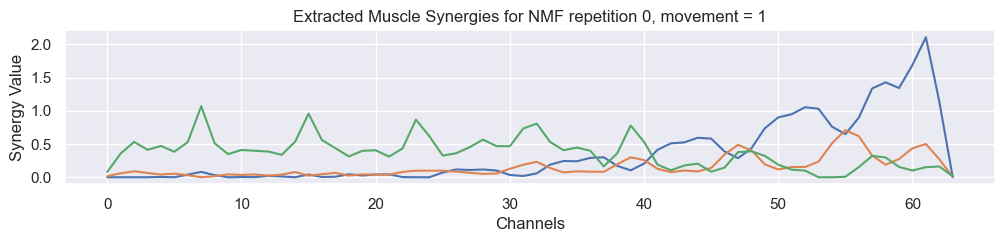

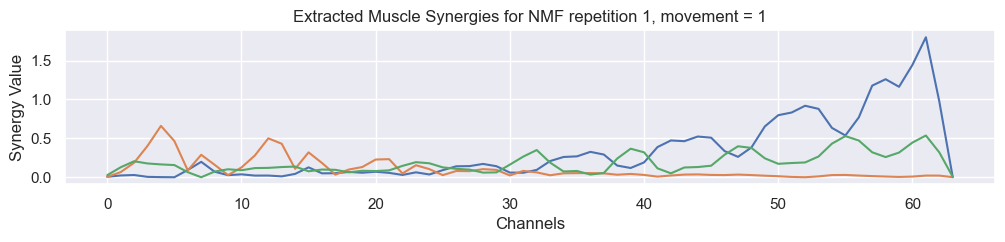

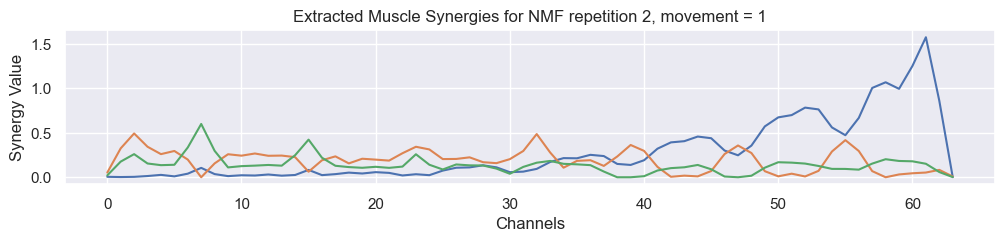

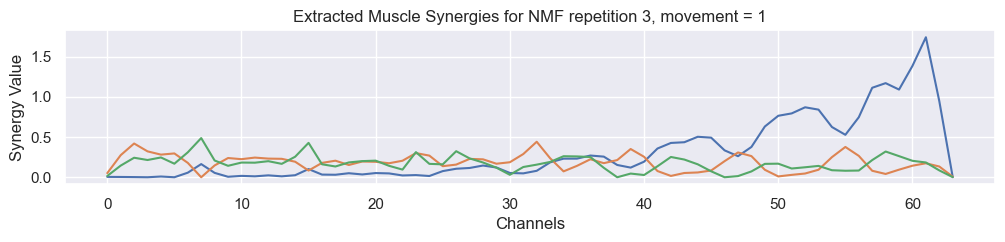

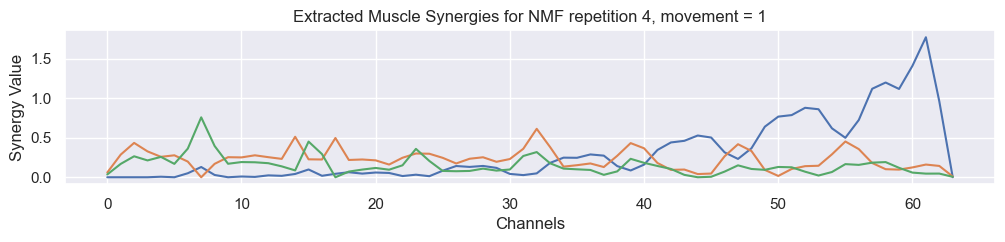

In [156]:
for rdx, muscle_synergy in enumerate(list_of_synergies_repetitions_one_movement_nmf):
    visualize_synergies(W=None, H=muscle_synergy, signal=None, names = ["", f" for NMF repetition {rdx}, movement = {movement_number}", ""],
                         all = False)

### b. Visualize for ICA

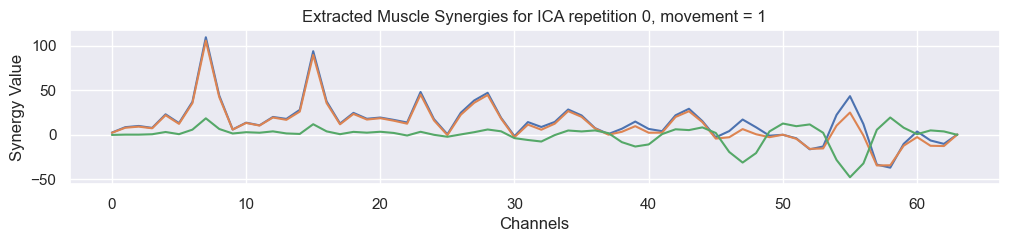

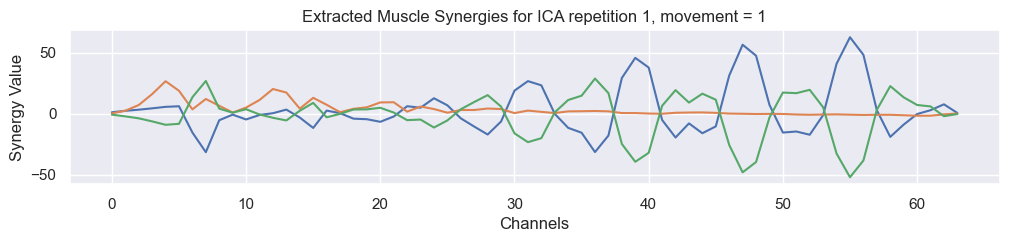

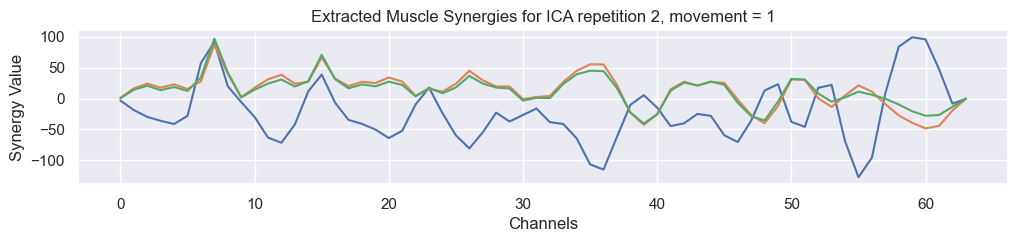

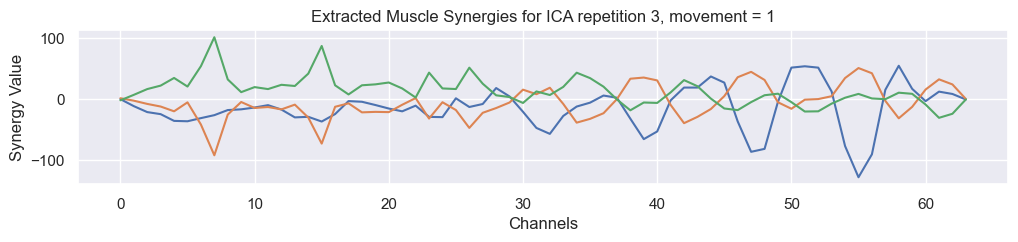

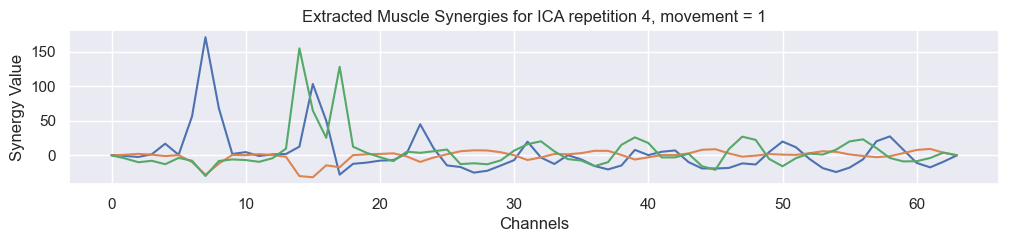

In [158]:
for rdx, muscle_synergy in enumerate(list_of_synergies_repetitions_one_movement_ica):
    visualize_synergies(W=None, H=muscle_synergy, signal=None, names = ["", f" for ICA repetition {rdx}, movement = {movement_number}", ""],
                         all = False)

### c. Visualize for PCA

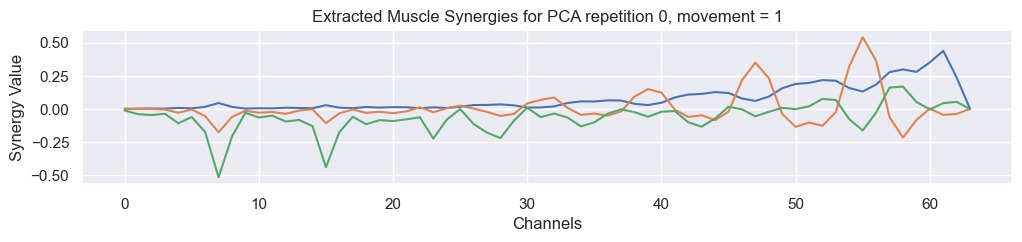

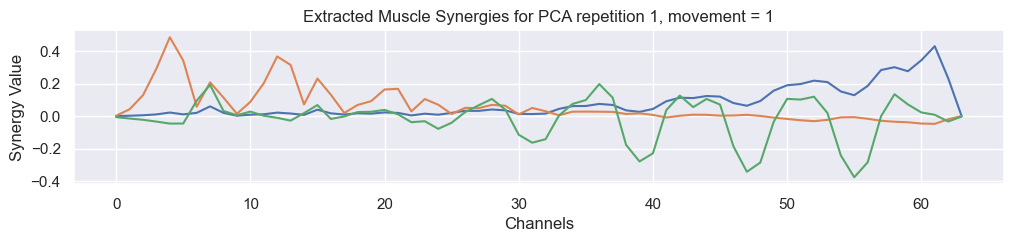

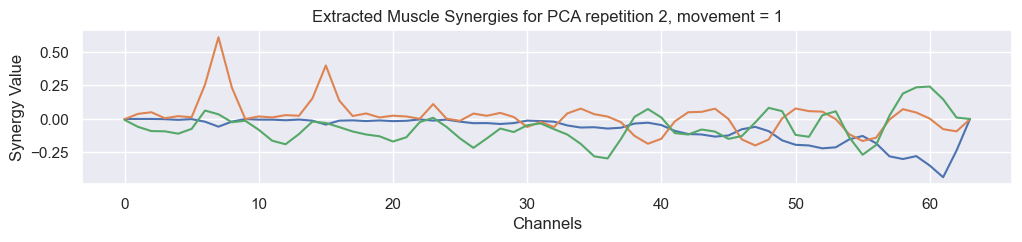

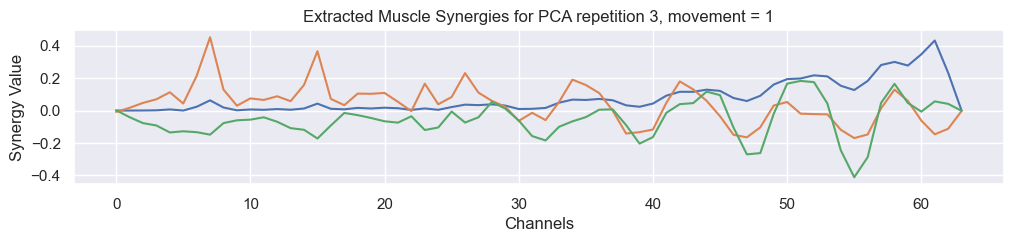

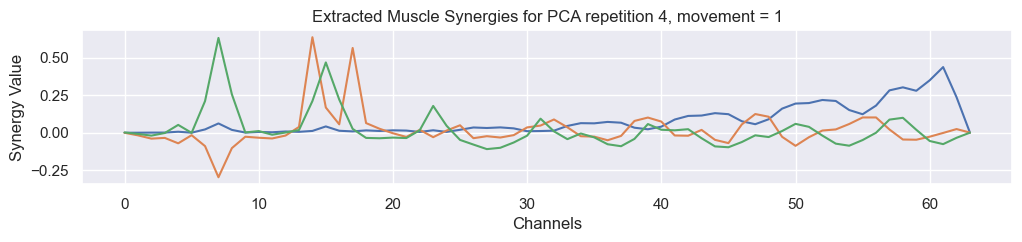

In [159]:
for rdx, muscle_synergy in enumerate(list_of_synergies_repetitions_one_movement_pca):
    visualize_synergies(W=None, H=muscle_synergy, signal=None, names = ["", f" for PCA repetition {rdx}, movement = {movement_number}", ""],
                         all = False)

In [28]:
print("NMF SSI =",compute_ssi(list_of_synergies_repetitions_one_movement_nmf),
        "\nICA SSI =",compute_ssi(list_of_synergies_repetitions_one_movement_ica),
        "\nPCA SSI =",compute_ssi(list_of_synergies_repetitions_one_movement_pca))

print("NMF SSI =",compute_ssi(list_of_synergies_repetitions_one_movement_nmf),
        "\nICA SSI =",compute_ssi(list_of_synergies_repetitions_one_movement_ica),
        "\nPCA SSI =",compute_ssi(list_of_synergies_repetitions_one_movement_pca),
        "\nPCA+ICA SSI =",compute_ssi(list_of_synergies_repetitions_one_movement_pca_ica))

NMF SSI = 0.5498622813617147 
ICA SSI = -0.06501980941017285 
PCA SSI = 0.08472436922713147
NMF SSI = 0.5498622813617147 
ICA SSI = -0.06501980941017285 
PCA SSI = 0.08472436922713147 
PCA+ICA SSI = -0.06512746943446326


And here we can see that NMF is more stable than the other methods for a single movement accross multiple trials

## 4. Compute the spatial synergies for different subjects. Is it now stable across the different subjects?

In [29]:
subj2_mat = io.loadmat('data/subj2_relevant_vars')
subject_2_data = { 
      "name": "subject 1",
      "sampling_frequency": subj2_mat['Fs'][0][0],
      "emg_signal": subj2_mat['emg_flexors_new'].reshape(subj2_mat['emg_flexors_new'].shape[0], 64),
      "hand_mouvement_label": subj2_mat["adjusted_class_new"].flatten(),
      "repetition_number": subj2_mat['adjusted_repetition_new'].flatten()
              }
subj3_mat = io.loadmat('data/subj3_relevant_vars')
subject_3_data = { 
      "name": "subject 1",
      "sampling_frequency": subj3_mat['Fs'][0][0],
      "emg_signal": subj3_mat['emg_flexors_new'].reshape(subj3_mat['emg_flexors_new'].shape[0], 64),
      "hand_mouvement_label": subj3_mat["adjusted_class_new"].flatten(),
      "repetition_number": subj3_mat['adjusted_repetition_new'].flatten()
              }

subject_2_preprocessed_data = preprocess_data(subject_2_data)
subject_3_preprocessed_data = preprocess_data(subject_3_data)

Elapsed time:  36.82017421722412
Elapsed time:  30.06641721725464


In [30]:
subject_1_id = np.ones(len(subject_1_preprocessed_data['emg_signal']))
subject_2_id = 2*np.ones(len(subject_2_preprocessed_data['emg_signal']))
subject_3_id = 3*np.ones(len(subject_3_preprocessed_data['emg_signal']))

signals_concat = np.concatenate([subject_1_preprocessed_data['emg_signal'],
                                subject_2_preprocessed_data['emg_signal'],
                                subject_3_preprocessed_data['emg_signal']])
ids_concat = np.concatenate([subject_1_id, subject_2_id, subject_3_id])
display(signals_concat.shape, ids_concat.shape)
df = pd.DataFrame(signals_concat)
df.insert(0, "subject_id", ids_concat)
df.insert(0, "subject_id_", ids_concat)
df.sample()

(3000000, 64)

(3000000,)

subject_id_  subject_id         0         1         2         3  \
2191259          2.0         2.0  0.000829  0.005843  0.008733  0.006611   

                4         5        6         7  ...       54        55  \
2191259  0.005247  0.005307  0.00685  0.007185  ...  0.00684  0.006992   

              56        57        58        59        60        61        62  \
2191259  0.00709  0.008687  0.008942  0.013103  0.011322  0.046273  0.055895   

               63  
2191259  0.000128  

[1 rows x 66 columns]

In [31]:
print("nmf")
list_of_synergies_subjects_nmf = synergies_across_subsets(df, method=nmf, subset_category="subject_id")
print("ica")
list_of_synergies_subjects_ica = synergies_across_subsets(df, method=ica, subset_category="subject_id")
print("pca")
list_of_synergies_subjects_pca = synergies_across_subsets(df, method=pca, subset_category="subject_id")
print("pca+ica")
list_of_synergies_subjects_pca_ica = synergies_across_subsets_pca_ica(df, subset_category="subject_id")

nmf
ica
pca
pca+ica


### a. Visualize for NMF

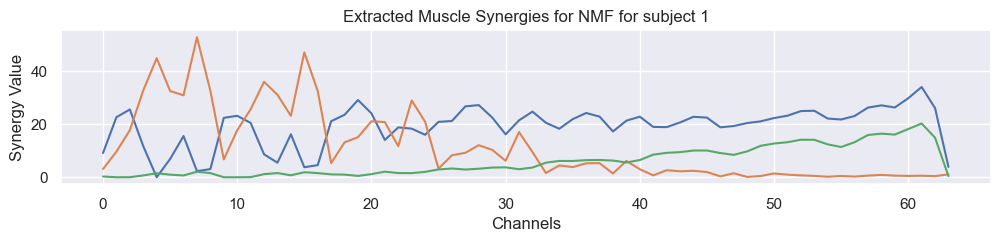

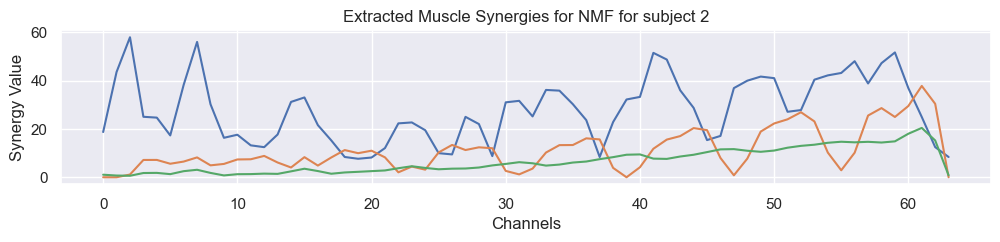

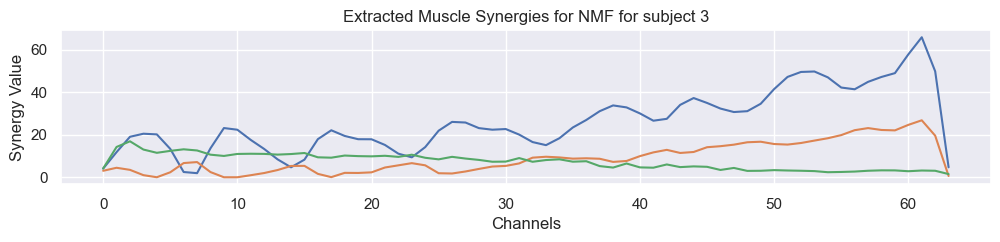

In [160]:
for rdx, muscle_synergy in enumerate(list_of_synergies_subjects_nmf):
    visualize_synergies(W=None, H=muscle_synergy, signal=None, names = ["", f" for NMF for subject {rdx+1}", ""],
                         all = False)

### b. Visualize for ICA

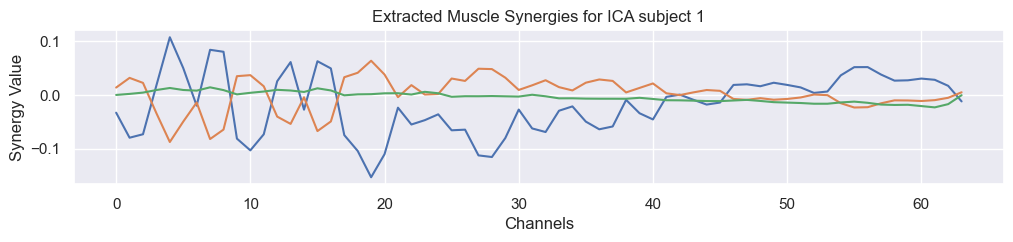

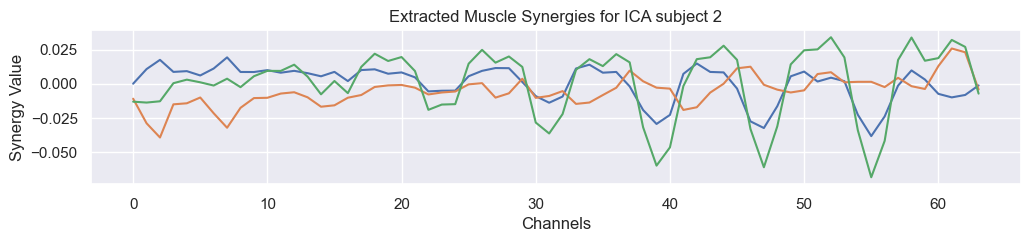

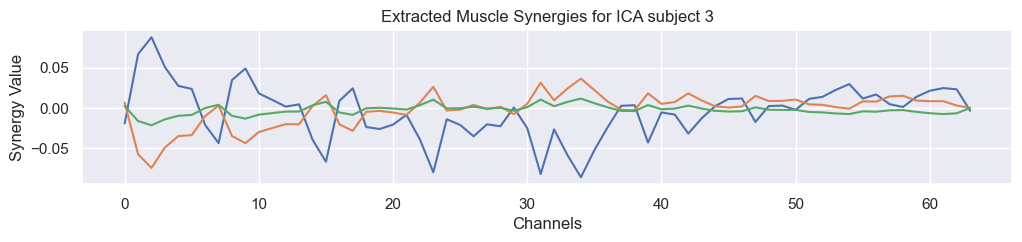

In [161]:
for rdx, muscle_synergy in enumerate(list_of_synergies_subjects_ica):
    visualize_synergies(W=None, H=muscle_synergy, signal=None, names = ["", f" for ICA subject {rdx+1}", ""],
                         all = False)

### c. Visualize for PCA

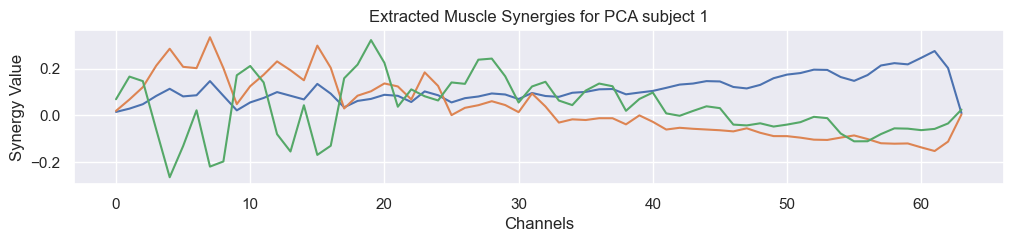

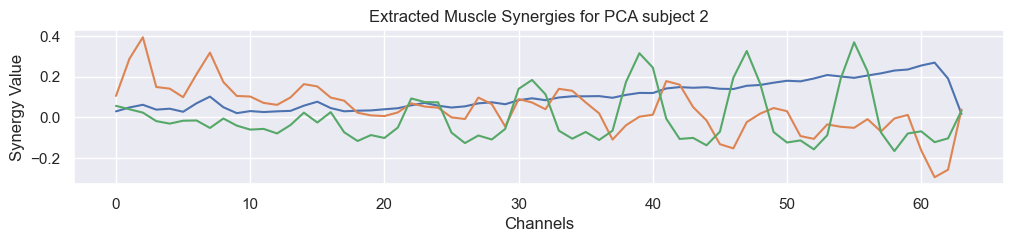

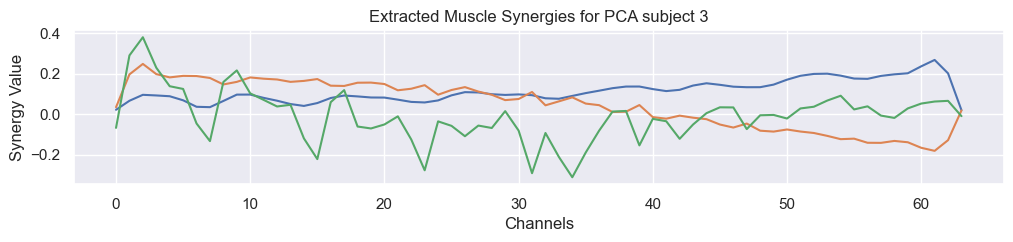

In [162]:
for rdx, muscle_synergy in enumerate(list_of_synergies_subjects_pca):
    visualize_synergies(W=None, H=muscle_synergy, signal=None, names = ["", f" for PCA subject {rdx+1}", ""],
                         all = False)

### What about the stability of our synergies accross subjects?

In [32]:
print("NMF SSI =",compute_ssi(list_of_synergies_subjects_nmf),
        "\nICA SSI =",compute_ssi(list_of_synergies_subjects_ica),
        "\nPCA SSI =",compute_ssi(list_of_synergies_subjects_pca))

print("NMF SSI =",compute_ssi(list_of_synergies_subjects_nmf),
        "\nICA SSI =",compute_ssi(list_of_synergies_subjects_ica),
        "\nPCA SSI =",compute_ssi(list_of_synergies_subjects_pca),
        "\nPCA+ICA SSI =",compute_ssi(list_of_synergies_subjects_pca_ica))

NMF SSI = 0.13004912295653517 
ICA SSI = -0.1428288981889439 
PCA SSI = 0.2539881910591312
NMF SSI = 0.13004912295653517 
ICA SSI = -0.1428288981889439 
PCA SSI = 0.2539881910591312 
PCA+ICA SSI = 0.03376881315969314



### 5. Try to vary the frequencies used in the preprocessing step. Compute the spatial synergies again. Does the choice of filtering frequencies affects the stability of the synergies?

We will use the 3 frequency ranges for our preprocessing

In [33]:
ranges = [(5, 500), (5, 250), (5, 100)]

preprocessed_frequency_ranges_subject_1 = [preprocess_data(subject_1_data, Wn=ranges[i]) for i in range(len(ranges))]
frequency_range_1_id = np.ones(len(preprocessed_frequency_ranges_subject_1[0]['emg_signal']))
frequency_range_2_id = 2*np.ones(len(preprocessed_frequency_ranges_subject_1[0]['emg_signal']))
frequency_range_3_id = 3*np.ones(len(preprocessed_frequency_ranges_subject_1[0]['emg_signal']))

signals_concat = np.concatenate([preprocessed_frequency_ranges_subject_1[i]['emg_signal'] for i in range(len(ranges))])
ids_concat = np.concatenate([frequency_range_1_id, frequency_range_2_id, frequency_range_3_id])

display(signals_concat.shape, ids_concat.shape)
df = pd.DataFrame(signals_concat)
df.insert(0, "frequency_range_id", ids_concat)
df.insert(0, "frequency_range_id_", ids_concat)
df.sample()

Elapsed time:  46.362942695617676
Elapsed time:  23.927008390426636
Elapsed time:  22.005494117736816


(2250000, 64)

(2250000,)

frequency_range_id_  frequency_range_id        0         1         2  \
1753815                  3.0                 3.0  0.00133  0.001282  0.001509   

                3         4         5        6         7  ...        54  \
1753815  0.001948  0.002506  0.003084  0.00359  0.003957  ...  0.040008   

               55        56        57        58        59        60        61  \
1753815  0.040195  0.038401  0.034567  0.028953  0.022144  0.014985  0.008447   

               62       63  
1753815  0.003432  0.00059  

[1 rows x 66 columns]

In [35]:
print("nmf")
list_of_synergies_frequency_nmf = synergies_across_subsets(df, method=nmf, subset_category="frequency_range_id")
print("ica")
list_of_synergies_frequency_ica = synergies_across_subsets(df, method=ica, subset_category="frequency_range_id")
print("pca")
list_of_synergies_frequency_pca = synergies_across_subsets(df, method=pca, subset_category="frequency_range_id")

print("pca+ica")
list_of_synergies_frequency_pca_ica = synergies_across_subsets_pca_ica(df, subset_category="frequency_range_id")

nmf
ica
pca
pca+ica


### a. Visualize for NMF

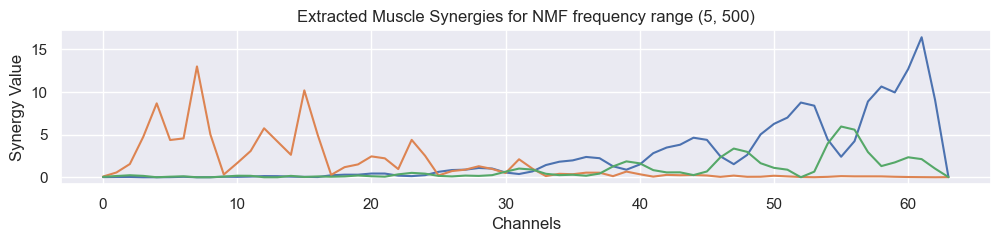

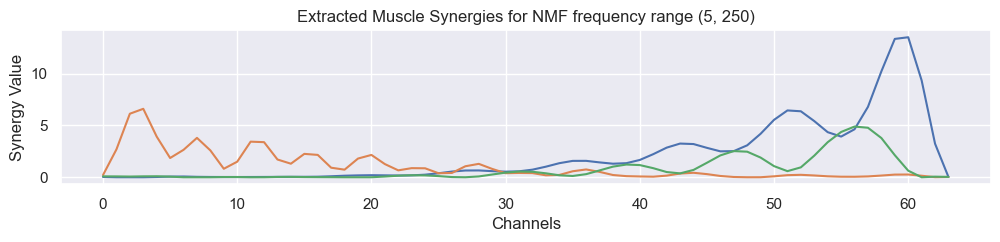

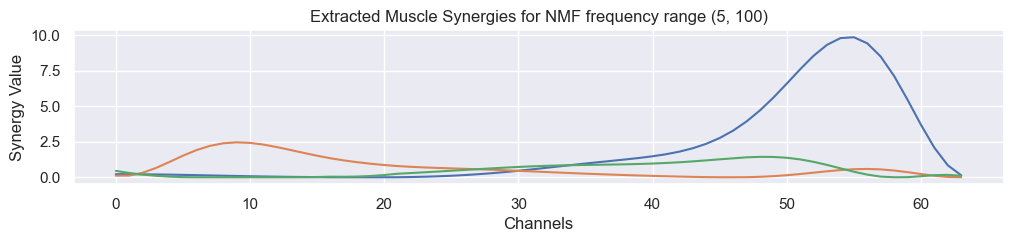

In [189]:
for rdx, muscle_synergy in enumerate(list_of_synergies_frequency_nmf):
    visualize_synergies(W=None, H=muscle_synergy, signal=None, names = ["", f" for NMF frequency range {ranges[rdx]}", ""],
                         all = False)

### b. Visualize For ICA

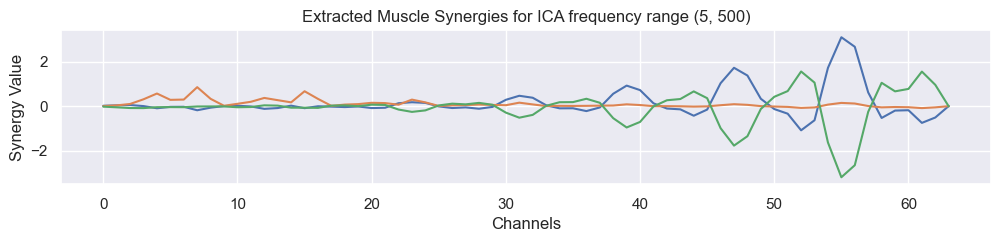

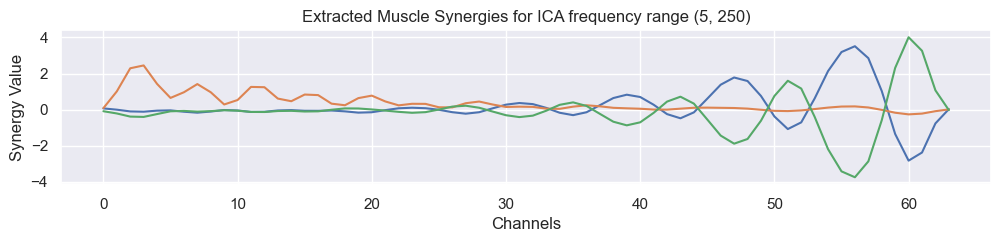

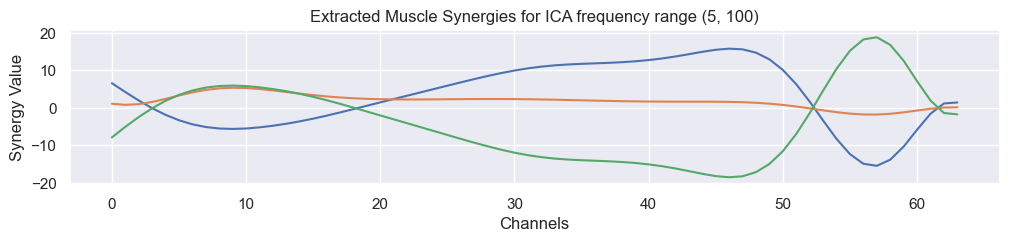

In [190]:
for rdx, muscle_synergy in enumerate(list_of_synergies_frequency_ica):
    visualize_synergies(W=None, H=muscle_synergy, signal=None, names = ["", f" for ICA frequency range {ranges[rdx]}", ""],
                         all = False)

### c. Visualize for PCA

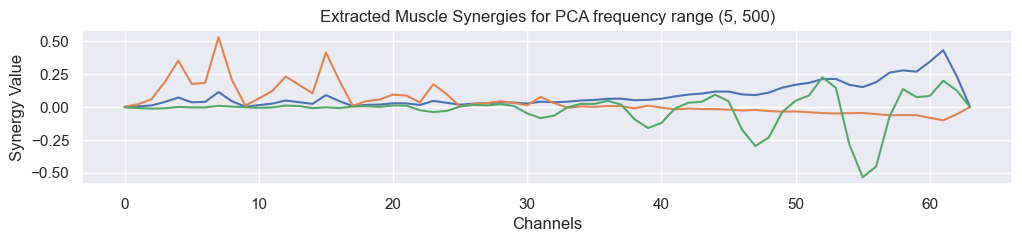

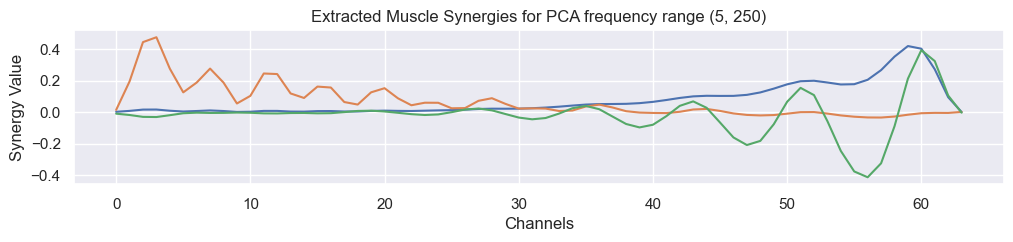

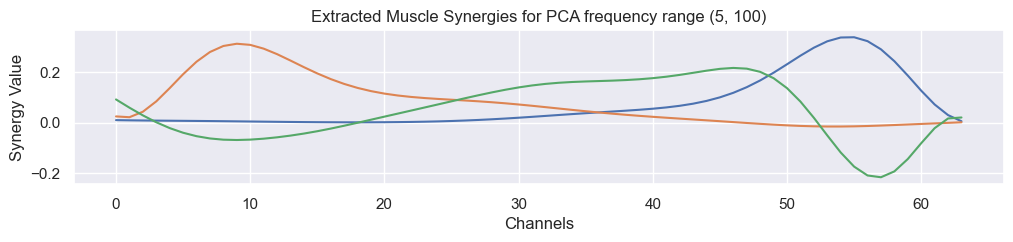

In [191]:
for rdx, muscle_synergy in enumerate(list_of_synergies_frequency_pca):
    visualize_synergies(W=None, H=muscle_synergy, signal=None, names = ["", f" for PCA frequency range {ranges[rdx]}", ""],
                         all = False)

In [36]:
print("NMF SSI =",compute_ssi(list_of_synergies_frequency_nmf),
        "\nICA SSI =",compute_ssi(list_of_synergies_frequency_ica),
        "\nPCA SSI =",compute_ssi(list_of_synergies_frequency_pca))

print("NMF SSI =",compute_ssi(list_of_synergies_frequency_nmf),
        "\nICA SSI =",compute_ssi(list_of_synergies_frequency_ica),
        "\nPCA SSI =",compute_ssi(list_of_synergies_frequency_pca),
        "\nPCA+ICA SSI =",compute_ssi(list_of_synergies_frequency_pca_ica))

NMF SSI = 0.6411405378379934 
ICA SSI = 0.4735181556753424 
PCA SSI = 0.5149249941177485
NMF SSI = 0.6411405378379934 
ICA SSI = 0.4735181556753424 
PCA SSI = 0.5149249941177485 
PCA+ICA SSI = 0.23677441813590927


## 6. Evaluate the stability of the synergies across the different BSS algorithms with respect to the tasks 3-4-5. Which algorithm performs better, and which one is least stable. Discuss the pros and cons of the different algorithms.

We answered question 6, throughout each question calculating and visualizing each of the muscle synergies and the comparing the stability of each synergy.

Throughout the notebook we also chose to go with 3 components for each of our BSS algorithms and this choice was backed up by the following 


### Reconstruction Error

In [193]:
def compute_reconstruction_err(original_data, max_components):
    re_nmf = np.zeros(max_components)
    re_pca = np.zeros(max_components)
    re_ica = np.zeros(max_components)
    
    for i in range(max_components):
        nmf = NMF(n_components=(i + 2), init="nndsvda", max_iter=500)
        pca = PCA(n_components=(i + 2))
        ica = FastICA(n_components=(i + 2), max_iter=500)
        print("Fitting BSS with {} components".format(i + 2))
        nmf.fit(original_data)
        x_pca = pca.fit_transform(original_data)
        x_ica = ica.fit_transform(original_data)
        print("Reconstructing err BSS with {} components".format(i + 2))
        re_nmf[i] = nmf.reconstruction_err_
        x_approx_pca = pca.inverse_transform(x_pca)
        x_approx_ica = ica.inverse_transform(x_ica)
        re_pca[i]= np.linalg.norm(original_data - x_approx_pca, 'fro')
        re_ica[i] = np.linalg.norm(original_data - x_approx_ica, 'fro')

    reconstructions_err = [re_nmf, re_pca, re_ica]


    return reconstructions_err

In [195]:
signal = subject_1_preprocessed_data['emg_signal']
err = compute_reconstruction_err(original_data=signal, max_components=8) #means number + 1

Fitting BSS with 2 components
Reconstructing err BSS with 2 components
Fitting BSS with 3 components
Reconstructing err BSS with 3 components
Fitting BSS with 4 components
Reconstructing err BSS with 4 components
Fitting BSS with 5 components
Reconstructing err BSS with 5 components
Fitting BSS with 6 components
Reconstructing err BSS with 6 components
Fitting BSS with 7 components


/Users/leger/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Reconstructing err BSS with 7 components
Fitting BSS with 8 components
Reconstructing err BSS with 8 components
Fitting BSS with 9 components


/Users/leger/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Reconstructing err BSS with 9 components


Text(0, 0.5, 'Reconstructed error')

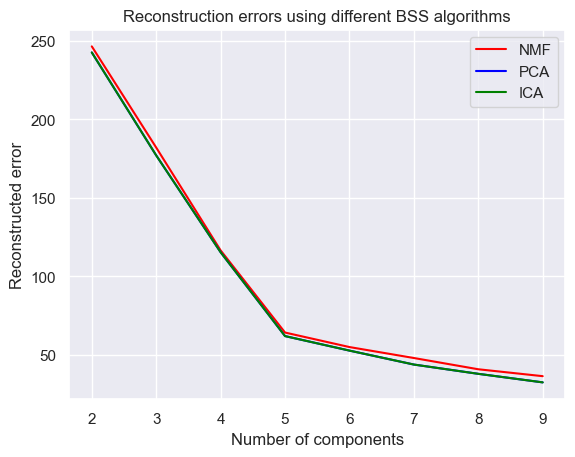

In [197]:
fig, ax = plt.subplots()
ax.plot(np.arange(2, 10), err[0], color = 'red', label="NMF")
ax.plot(np.arange(2, 10), err[1], color = 'blue', label="PCA")
ax.plot(np.arange(2,10), err[2], color = 'green',   label='ICA')
plt.legend()
plt.title('Reconstruction errors using different BSS algorithms')
plt.xlabel('Number of components')
plt.ylabel('Reconstructed error')

And so we can see by elbow method that the best number of components would be n=5, however after calculating the VAF, we see that we already have a great 99% VAF value with 3 components so thats why we chose only 3 components

## VAF*

In [115]:
signal = subject_1_preprocessed_data['emg_signal']

VAF = []
for n_comp in range(1, 10):
    pca = FastICA(n_components=n_comp, random_state=0)
    W_pca = pca.fit_transform(signal)
    H_pca = pca.components_
    vaf_bss = 1 - (np.linalg.norm((signal - W_pca.dot(H_pca))**2)/(np.linalg.norm(signal)**2))
    print(vaf_bss)
    VAF.append(vaf_bss)
    print("W, H shape for pca", W_pca.shape, H_pca.shape)

0.9996154967553765
W, H shape for pca (750000, 1) (1, 64)
0.9996174218693686
W, H shape for pca (750000, 2) (2, 64)
0.9996196086473533
W, H shape for pca (750000, 3) (3, 64)
0.9996216210183381
W, H shape for pca (750000, 4) (4, 64)
0.9996238721345878
W, H shape for pca (750000, 5) (5, 64)
0.9996226689332874
W, H shape for pca (750000, 6) (6, 64)
0.9996185631407463
W, H shape for pca (750000, 7) (7, 64)
0.9996112472720902
W, H shape for pca (750000, 8) (8, 64)
0.9996053605320544
W, H shape for pca (750000, 9) (9, 64)
